In [32]:
import numpy as np 
import pandas as pd 

In [33]:
df = pd.read_csv('../DataOut/bus_running_times_feature_added_all_moddedDF.csv')

In [34]:
df.head(20)

,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,conditions,dt(n-1)
0,4890.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1.0,10.0,20.0,0.000,6.1,Partially cloudy,0.0
1,4890.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1.0,10.0,20.0,0.000,6.1,Partially cloudy,74.0
2,4890.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1.0,10.0,20.0,0.000,6.1,Partially cloudy,0.0
3,4890.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1.0,10.0,20.0,0.000,6.1,Partially cloudy,6.0
4,4890.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1.0,10.0,20.0,0.000,6.1,Partially cloudy,0.0
5,4890.0,262.0,1.0,6.0,2021-10-01,07:02:27,07:05:57,0 days 00:03:30,210.0,1.3125,4.0,7.00,0.0,0,1,1.0,220.0,220.0,220.0,220.0,220.0,97.0,195.0,496.0,7.0,1.0,10.0,20.7,0.000,6.8,Partially cloudy,211.0
6,4890.0,262.0,1.0,7.0,2021-10-01,07:06:32,07:07:17,0 days 00:00:45,45.0,0.3713,4.0,7.00,0.0,0,1,1.0,39.0,39.0,39.0,39.0,39.0,210.0,97.0,195.0,7.0,1.0,10.0,20.7,0.000,6.8,Partially cloudy,35.0
7,4890.0,262.0,1.0,8.0,2021-10-01,07:07:42,07:09:21,0 days 00:01:39,99.0,0.6245,4.0,7.00,0.0,0,1,1.0,74.0,74.0,74.0,74.0,74.0,45.0,210.0,97.0,7.0,1.0,10.0,20.7,0.000,6.8,Partially cloudy,25.0
8,4890.0,262.0,1.0,9.0,2021-10-01,07:09:44,07:10:18,0 days 00:00:34,34.0,0.2572,4.0,7.00,0.0,0,1,1.0,26.0,26.0,26.0,26.0,26.0,99.0,45.0,210.0,7.0,1.0,10.0,20.7,0.000,6.8,Partially cloudy,23.0
9,4890.0,262.0,1.0,10.0,2021-10-01,07:11:02,07:13:31,0 days 00:02:29,149.0,1.2349,4.0,7.00,0.0,0,1,1.0,157.0,157.0,157.0,157.0,157.0,34.0,99.0,45.0,7.0,1.0,10.0,20.7,0.000,6.8,Partially cloudy,44.0


In [35]:
# # drop raws after 	'2022-11-01' from df
df = df[df['date']<='2022-11-01']

In [36]:
# show all the columns in pandas dataframes
pd.set_option('display.max_columns', None)

In [37]:
# drop raws where run_time_in_seconds has nan values
df = df.dropna(subset=['run_time_in_seconds'])

In [38]:
def prepare(df):
    df['date'] = pd.to_datetime(df['date'])
    df['start_time'] = pd.to_datetime(df['start_time'],
                                    format='%H:%M:%S').dt.time

    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    df.drop(['run_time'], axis=1,inplace = True)
    df.drop(['end_time'], axis=1,inplace = True)

    #replace ' partially cloudy' with 'partially cloudy'
    df['conditions'] = df['conditions'].replace(' Partially cloudy', 'Partially cloudy')


    from sklearn.preprocessing import OrdinalEncoder

    # Replace NaN values in the 'conditions' column with 'Unknown'
    df['conditions'].fillna('Unknown', inplace=True)

    conditions = ['Rain', 'Rain, Overcast', 'Rain, Partially cloudy', 'Overcast', 'Partially cloudy', 'Clear','Unknown']
    encoder = OrdinalEncoder(categories=[conditions])
    df['conditions_encoded'] = encoder.fit_transform(df[['conditions']])

    # Now, you can drop the original 'conditions' column if needed
    df = df.drop(['conditions'], axis=1)

    df['start_float'] = df['start_time'].apply(lambda x: x.hour + x.minute/60.0 + x.second/3600.0)

    # drop 
    df = df.drop(['start_time'], axis=1)

    # Drop the original date column
    df.drop('date', axis=1, inplace=True)
    
    return df

df=prepare(df)

# XG boost Model


In [39]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_rmse_dict = {}

def train_Model(df):
    # Split the data into two sets based on the week number for Code Block 1
    test_data = df[df['week_no'].isin([39, 40, 41, 42])]
    train_data = df[~df['week_no'].isin([39, 40, 41, 42])]

    X_train, X_test = train_data.drop(['run_time_in_seconds'], axis=1), test_data.drop(['run_time_in_seconds'], axis=1)
    y_train, y_test = train_data['run_time_in_seconds'], test_data['run_time_in_seconds']


    # Initialize XGBoost regressor for Code Block 1
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

    # Train the model on the training data for Code Block 1
    model.fit(X_train, y_train)

    # Make predictions on the testing data for Code Block 1
    predictions = model.predict(X_test)
    
        # Create a copy of the test data and add predicted values for Code Block 2
    predicted_df = test_data.copy()
    predicted_df['predicted_run_time'] = predictions

    # Evaluate the model's performance for Code Block 1
    mae1 = mean_absolute_error(y_test, predictions)
    rmse1 = np.sqrt(mean_squared_error(y_test, predictions))
    mape1 = np.mean(np.abs((y_test - predictions) / y_test)) * 100
    
    
    
    
    return model, predictions, predicted_df, mae1, rmse1,mape1

# XG boost without clusters

In [40]:
# daf_no_clus1 = df[df['direction'] == 1].copy()

daf_no_clus1=df.copy()

In [41]:
daf_no_clus1

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),year,conditions_encoded,start_float
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,2021,4.0,6.663611
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,2021,4.0,6.703333
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,2021,4.0,6.761667
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,2021,4.0,6.901111
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,2021,4.0,6.955278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197627,3462.0,123.0,2.0,28.0,99.0,0.8700,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31,10,22.2,0.0,4.3,9.0,2022,4.0,18.762222
197628,3462.0,123.0,2.0,29.0,165.0,1.4000,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31,10,22.2,0.0,4.3,15.0,2022,4.0,18.793889
197629,3462.0,123.0,2.0,30.0,337.0,2.5600,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31,10,22.2,0.0,4.3,33.0,2022,4.0,18.848889
197630,3462.0,123.0,2.0,31.0,46.0,0.4200,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31,10,22.2,0.0,4.3,15.0,2022,4.0,18.946667


In [42]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features and target for Code Block 1
features1 = daf_no_clus1.drop(['run_time_in_seconds'], axis=1)
target1 = daf_no_clus1['run_time_in_seconds']

model1,predictions1,predicted_df1,mae1,rmse1,mape1 = train_Model(daf_no_clus1)

mae_rmse_dict["without clusters"] = [mae1, rmse1,mape1,model1]

mae_rmse_dict["skip 1"] = " "

print(f'Mean Absolute Error without cluster: {mae1}')
print(f'Root Mean Square Error  without cluster: {rmse1}')
print(f'Mean Absolute Percentage Error without cluster: {mape1}')


Mean Absolute Error without cluster: 31.8700449616019
Root Mean Square Error  without cluster: 51.52166695962722
Mean Absolute Percentage Error without cluster: 19.07566235351023


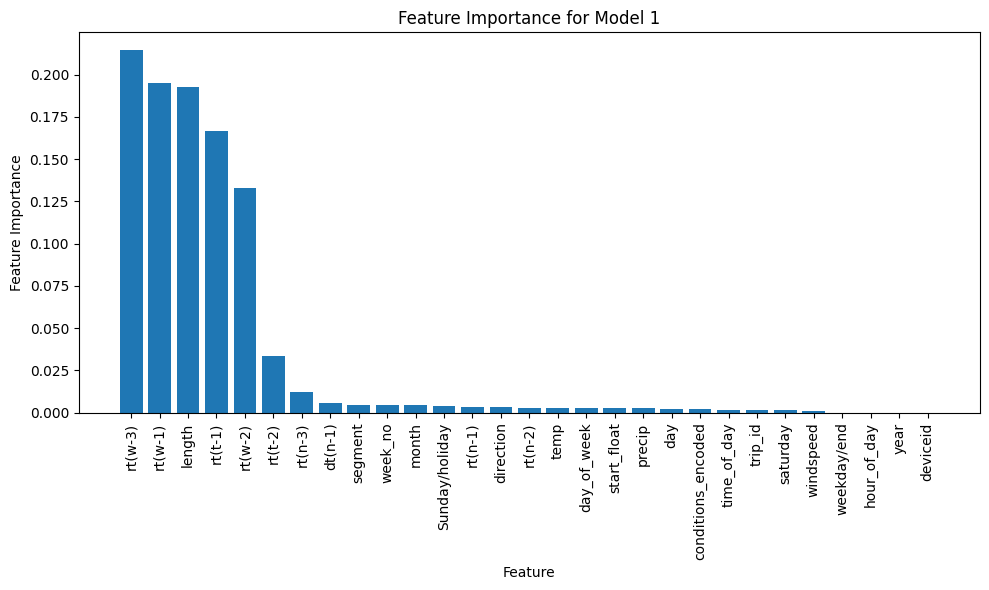

In [43]:
import matplotlib.pyplot as plt

# Get feature importances for Model 1
feature_importance1 = model1.feature_importances_

# Get the names of the features
feature_names1 = features1.columns

# Sort feature importances and feature names in descending order
sorted_idx1 = feature_importance1.argsort()[::-1]
feature_importance1 = feature_importance1[sorted_idx1]
feature_names1 = feature_names1[sorted_idx1]

# Create a bar graph for Model 1
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance1)), feature_importance1, align='center')
plt.xticks(range(len(feature_importance1)), feature_names1, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Model 1')
plt.tight_layout()
plt.show()


# XG boost with segment clusters

In [44]:
# read '../DataOut/bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test.csv'
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test = pd.read_csv('../DataOut/bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test_normway.csv')
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test


,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before,speed_1_segment_before,last_trip_cluster,norm_cluster_mode
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,NaN,NaN,NaN,4.117171,NaN,0.0
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,0.0,33.0,11.0,55.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,0.0,NaN,NaN,10.475160,NaN,0.0
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,0.0,0.0,NaN,7.991364,NaN,2.0
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,33.0,11.0,55.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,0.0,0.0,0.0,7.590256,NaN,1.0
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,33.0,11.0,55.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,1.0,0.0,0.0,14.463141,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,9131.0,284.0,1.0,11.0,97.0,1.1000,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944,1,16.857172,-0.121372,3.783189,29.394737,30.894737,1.0,1.0,1.0,20.523937,1.0,2.0
100368,9131.0,284.0,1.0,12.0,133.0,1.3100,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889,1,17.361381,-0.120115,3.513575,32.289474,34.315789,1.0,1.0,1.0,18.484769,1.0,1.0
100369,9131.0,284.0,1.0,13.0,141.0,1.1500,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833,1,17.966975,-0.186211,3.638588,27.394737,29.105263,1.0,1.0,1.0,19.531022,1.0,1.0
100370,9131.0,284.0,1.0,14.0,91.0,0.8900,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000,1,16.828766,-0.207720,3.158288,20.236842,22.342105,1.0,1.0,1.0,18.599116,1.0,1.0


In [45]:
# drop a some columns
# bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test = bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test.drop(['cluster_in_1_segment_before','cluster_in_2_segment_before','cluster_in_3_segment_before','last_trip_cluster','norm_cluster_mode','norm_cluster'], axis=1)

In [46]:
# number of rows with speed value is nan
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test['speed'].isna().sum()

0

In [47]:
# number of rows with direction is equal to 2
bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test[bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test['direction']==2].shape[0]

0

In [48]:
# daf_no_clus = bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test[bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test['direction'] == 1].copy()

daf_no_clus = bus_running_times_feature_added_all_with_Kmeans_cluster_pred_for_test
daf_no_clus

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before,speed_1_segment_before,last_trip_cluster,norm_cluster_mode
0,4890.0,262.0,1.0,1.0,69.0,0.6261,4.0,6.50,0.0,0,1,1.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,96.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.663611,0,6.551622,-0.263065,0.289582,1.333333,0.333333,NaN,NaN,NaN,4.117171,NaN,0.0
1,4890.0,262.0,1.0,2.0,210.0,1.2808,4.0,6.50,0.0,0,1,1.0,247.0,247.0,247.0,247.0,247.0,69.0,247.0,247.0,6.0,1,10,20.0,0.0,6.1,74.0,0.0,33.0,11.0,55.0,2021,4.0,6.703333,0,10.318498,-0.020071,0.876211,3.000000,1.000000,0.0,NaN,NaN,10.475160,NaN,0.0
2,4890.0,262.0,1.0,3.0,496.0,2.1125,4.0,6.75,0.0,0,1,1.0,506.0,506.0,506.0,506.0,506.0,210.0,69.0,506.0,6.0,1,10,20.0,0.0,6.1,0.0,0.0,33.0,11.0,55.0,2021,4.0,6.761667,0,9.510959,-0.306166,0.668537,7.500000,8.250000,0.0,0.0,NaN,7.991364,NaN,2.0
3,4890.0,262.0,1.0,4.0,195.0,1.5513,4.0,6.75,0.0,0,1,1.0,192.0,192.0,192.0,192.0,192.0,496.0,210.0,69.0,6.0,1,10,20.0,0.0,6.1,6.0,1.0,33.0,11.0,55.0,2021,4.0,6.901111,0,12.014774,-0.072601,0.425698,3.250000,3.750000,0.0,0.0,0.0,7.590256,NaN,1.0
4,4890.0,262.0,1.0,5.0,97.0,0.8450,4.0,6.75,0.0,0,1,1.0,114.0,114.0,114.0,114.0,114.0,195.0,496.0,210.0,6.0,1,10,20.0,0.0,6.1,0.0,1.0,33.0,11.0,55.0,2021,4.0,6.955278,0,14.626720,-0.645813,0.374014,1.250000,1.000000,1.0,0.0,0.0,14.463141,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,9131.0,284.0,1.0,11.0,97.0,1.1000,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944,1,16.857172,-0.121372,3.783189,29.394737,30.894737,1.0,1.0,1.0,20.523937,1.0,2.0
100368,9131.0,284.0,1.0,12.0,133.0,1.3100,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889,1,17.361381,-0.120115,3.513575,32.289474,34.315789,1.0,1.0,1.0,18.484769,1.0,1.0
100369,9131.0,284.0,1.0,13.0,141.0,1.1500,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833,1,17.966975,-0.186211,3.638588,27.394737,29.105263,1.0,1.0,1.0,19.531022,1.0,1.0
100370,9131.0,284.0,1.0,14.0,91.0,0.8900,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000,1,16.828766,-0.207720,3.158288,20.236842,22.342105,1.0,1.0,1.0,18.599116,1.0,1.0


In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define features and target for Code Block 1
features2 = daf_no_clus.drop(['run_time_in_seconds'], axis=1)
target2 = daf_no_clus['run_time_in_seconds']

model2,predictions2,predicted_df2,mae2,rmse2,mape2 = train_Model(daf_no_clus)

mae_rmse_dict["with segment clusters"] = [mae2, rmse2,mape2,model2]

mae_rmse_dict["skip 1"] = " "

print(f'Mean Absolute Error with segment cluster: {mae2}')
print(f'Root Mean Square Error  with segment cluster: {rmse2}')
print(f'Mean Absolute Percentage Error with segment cluster: {mape2}')


Mean Absolute Error with segment cluster: 29.532059887772434
Root Mean Square Error  with segment cluster: 48.832721329557884
Mean Absolute Percentage Error with segment cluster: 17.494081120490442


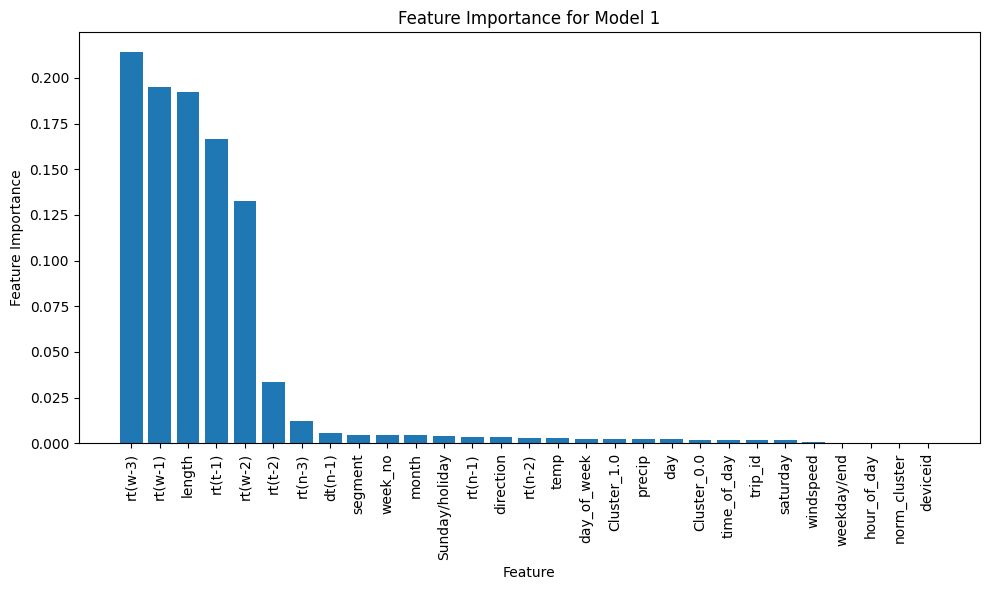

In [50]:
import matplotlib.pyplot as plt

# Get feature importances for Model 1
feature_importance1 = model1.feature_importances_

# Get the names of the features
feature_names1 = features2.columns

# Sort feature importances and feature names in descending order
sorted_idx1 = feature_importance1.argsort()[::-1]
feature_importance1 = feature_importance1[sorted_idx1]
feature_names1 = feature_names1[sorted_idx1]

# Create a bar graph for Model 1
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance1)), feature_importance1, align='center')
plt.xticks(range(len(feature_importance1)), feature_names1, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance for Model 1')
plt.tight_layout()
plt.show()


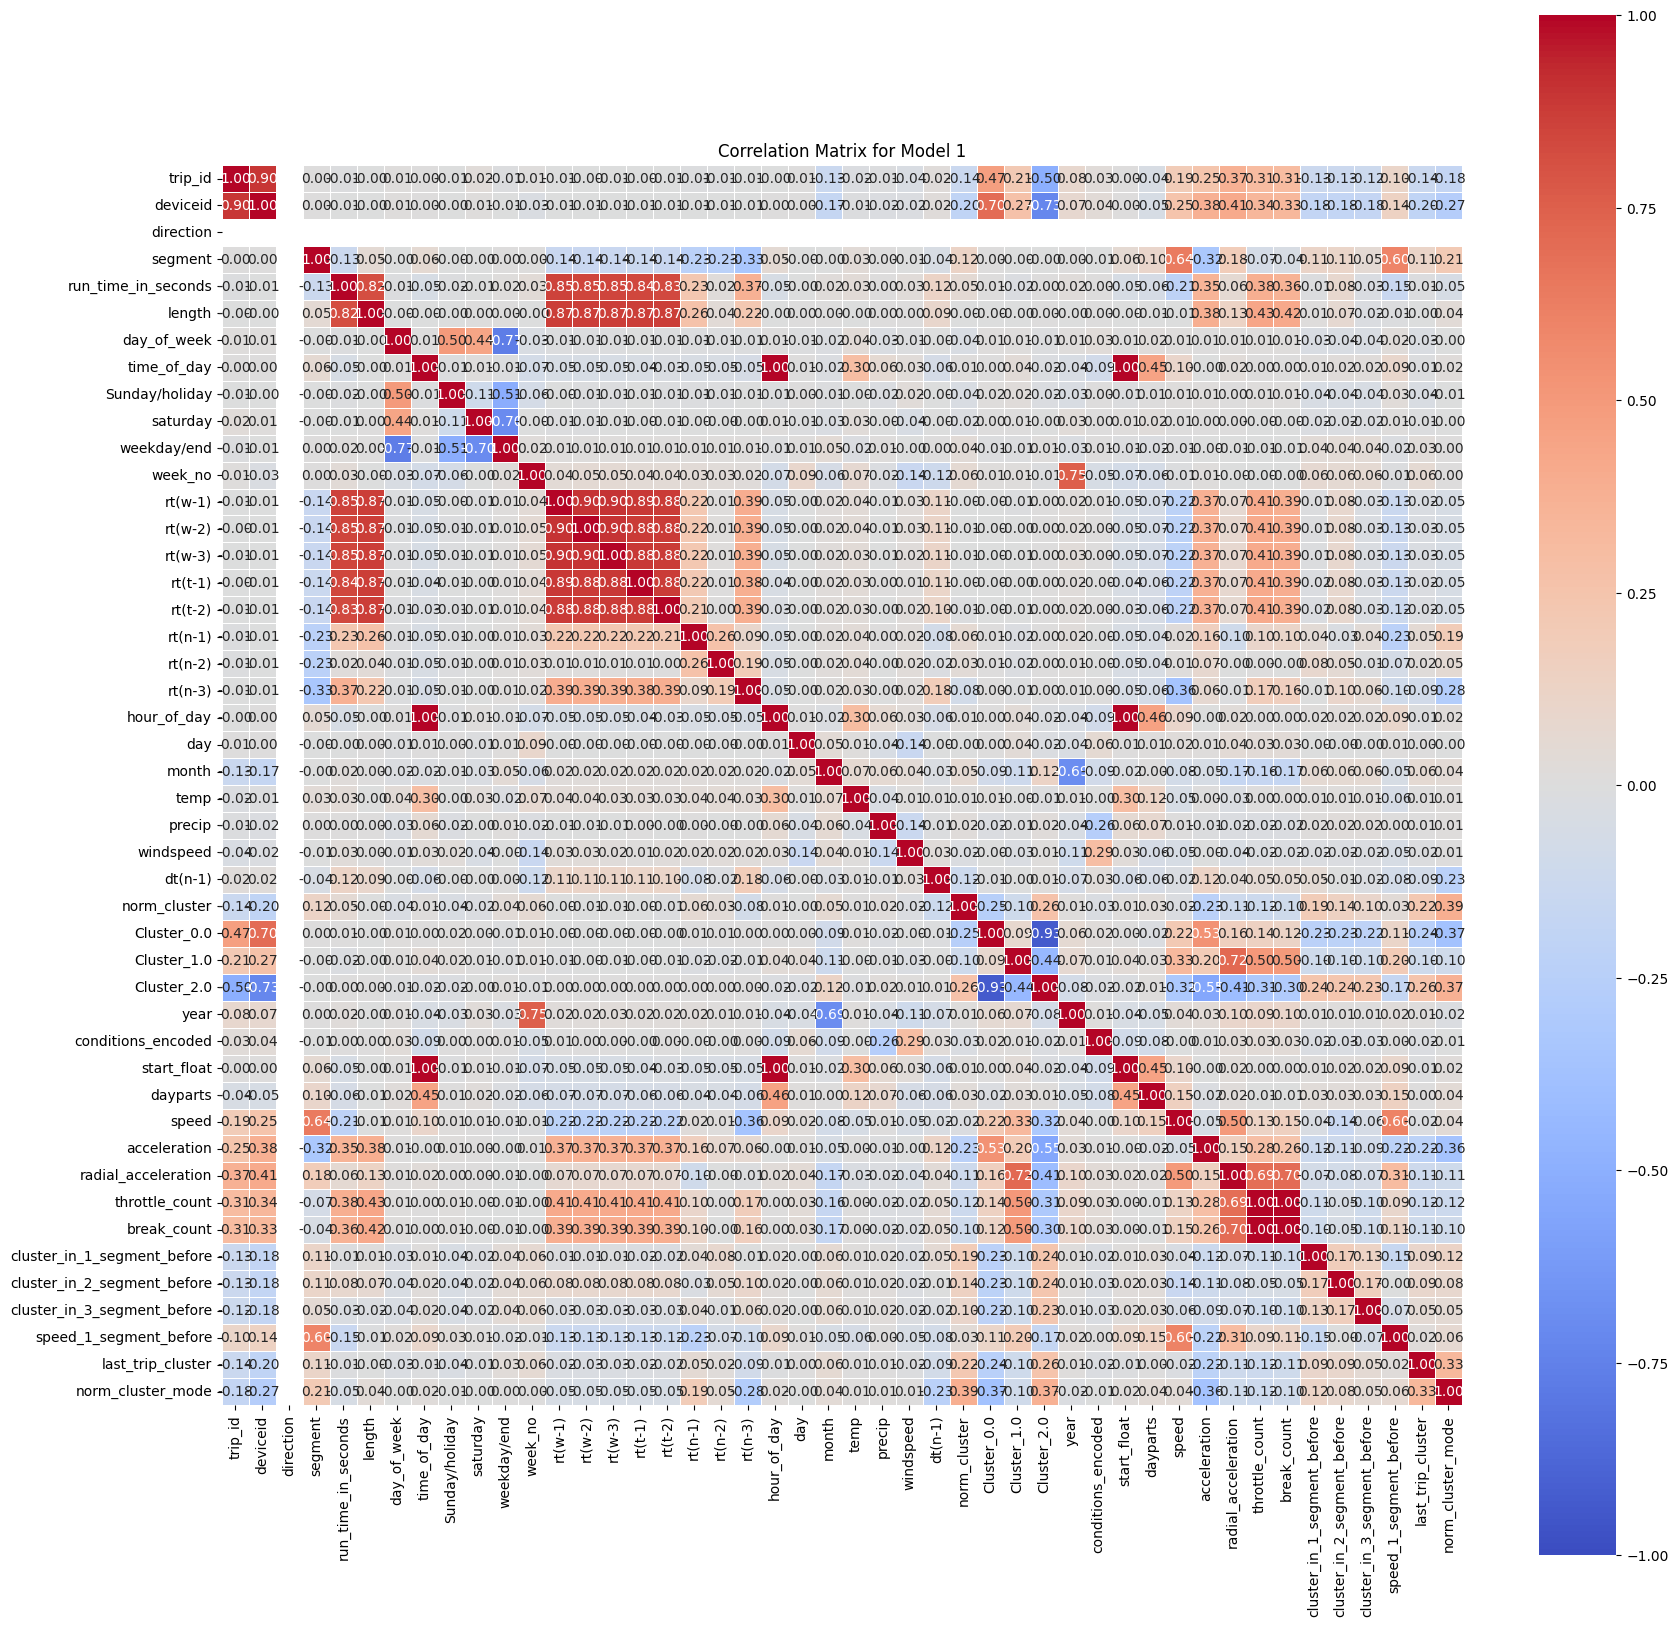

In [51]:
# Draw a corelation matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
corr = daf_no_clus.corr()

# Generate a mask for the upper triangle
# mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', vmax=1, vmin=-1, center=0, square=True, linewidths=.5, annot=True, fmt='.2f')
plt.title('Correlation Matrix for Model 1')
plt.show()


# Summery

In [52]:
# print mae and rmse for all models and get the best model
best_model = None
best_mae = None
best_rmse = None
for key, value in mae_rmse_dict.items():
    if key == "skip 1" or key == "skip 2" or key == "skip 3" or key == "skip 4" or key == "skip_5": 
        print(" ")
    else:
        print(f"{key} : MAE: {value[0]}, RMSE: {value[1]} , MAPE: {value[2]}")
        if best_model == None:
            best_model = key
            best_mae = value[0]
            best_rmse = value[1]
            best_mape = value[2]
        else:
            if value[0] < best_mae:
                best_model_name = key
                best_mae = value[0]
                best_rmse = value[1]
                best_mape = value[2]
                best_model= value[3]
                
print(" ")
print(f"Best model : {best_model_name} , MAE: {best_mae}, RMSE: {best_rmse} , MAPE: {best_mape}")
    
    

without clusters : MAE: 31.8700449616019, RMSE: 51.52166695962722 , MAPE: 19.07566235351023
 
with segment clusters : MAE: 29.532059887772434, RMSE: 48.832721329557884 , MAPE: 17.494081120490442
 
Best model : with segment clusters , MAE: 29.532059887772434, RMSE: 48.832721329557884 , MAPE: 17.494081120490442


In [53]:
# without clusters : MAE: 31.8700449616019, RMSE: 51.52166695962722 , MAPE: 19.07566235351023
 
# with segment clusters : MAE: 29.532059887772434, RMSE: 48.832721329557884 , MAPE: 17.494081120490442
 
# Best model : with segment clusters , MAE: 29.532059887772434, RMSE: 48.832721329557884 , MAPE: 17.494081120490442


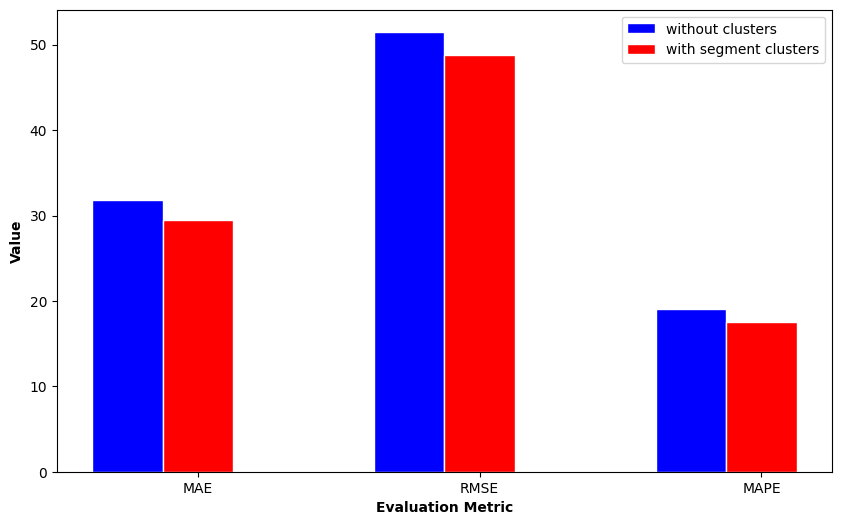

In [54]:
# draw the difference between MAE,RMSE and MAPE for best model vs the without clusters model on a side by side bar chart
import matplotlib.pyplot as plt
import numpy as np

# set width of bar

barWidth = 0.25

# set height of bar

bars1 = [mae_rmse_dict["without clusters"][0],mae_rmse_dict["without clusters"][1],mae_rmse_dict["without clusters"][2]]
bars2 = [mae_rmse_dict[best_model_name][0],mae_rmse_dict[best_model_name][1],mae_rmse_dict[best_model_name][2]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]


# Make the plot
plt.figure(figsize=(10, 6))
plt.bar(r1, bars1, color='blue', width=barWidth, edgecolor='white', label='without clusters')
plt.bar(r2, bars2, color='red', width=barWidth, edgecolor='white', label=best_model_name)

# Add xticks on the middle of the group bars
plt.xlabel('Evaluation Metric', fontweight='bold')
plt.ylabel('Value', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['MAE', 'RMSE', 'MAPE'])

# Create legend & Show graphic
plt.legend()
plt.show()




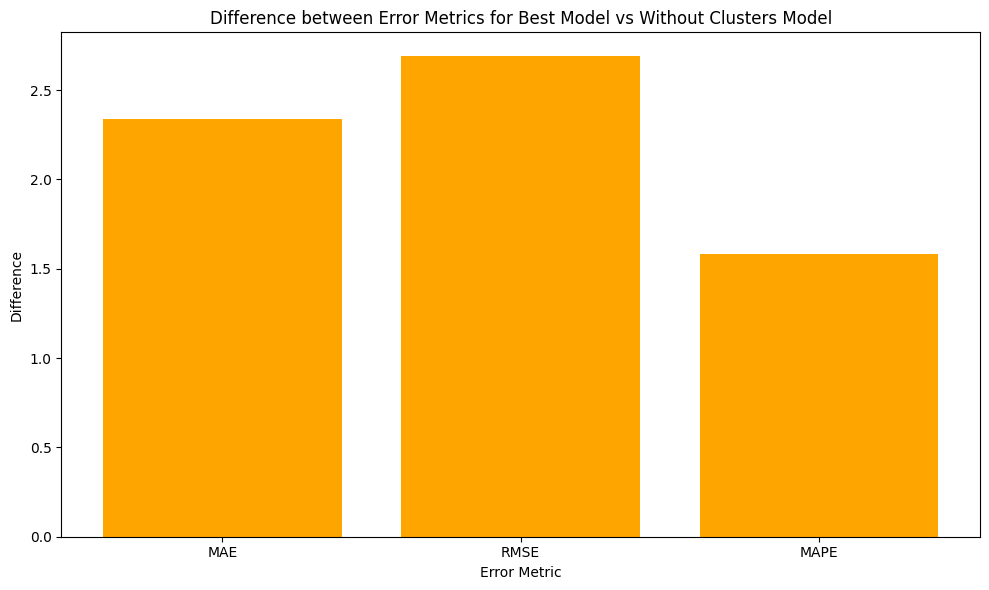

In [55]:
# draw the difference between MAE,RMSE and MAPE for best model vs the without clusters model on a multi bar graph with the 3 values for the difference of each error metric for each model.

# get the difference between MAE,RMSE and MAPE for best model vs the without clusters model
mae_diff = mae_rmse_dict['without clusters'][0] - mae_rmse_dict[best_model_name][0]
rmse_diff = mae_rmse_dict['without clusters'][1] - mae_rmse_dict[best_model_name][1]
mape_diff = mae_rmse_dict['without clusters'][2] - mae_rmse_dict[best_model_name][2]

# create a dataframe with the difference between MAE,RMSE and MAPE for best model vs the without clusters model
diff_df = pd.DataFrame({'Error Metric': ['MAE', 'RMSE', 'MAPE'],
                        'Difference': [mae_diff, rmse_diff, mape_diff]})
diff_df

# Create a bar graph for the difference between MAE,RMSE and MAPE for best model vs the without clusters model
plt.figure(figsize=(10, 6))
plt.bar(diff_df['Error Metric'], diff_df['Difference'], align='center',color='orange')
plt.xlabel('Error Metric')
plt.ylabel('Difference')
plt.title('Difference between Error Metrics for Best Model vs Without Clusters Model')
plt.tight_layout()
plt.show()


In [56]:
# export best xgboost model
import pickle
pickle.dump(best_model, open('../DataOut/runningtime_model.sav', 'wb'))

In [57]:
predicted_df2

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),norm_cluster,Cluster_0.0,Cluster_1.0,Cluster_2.0,year,conditions_encoded,start_float,dayparts,speed,acceleration,radial_acceleration,throttle_count,break_count,cluster_in_1_segment_before,cluster_in_2_segment_before,cluster_in_3_segment_before,speed_1_segment_before,last_trip_cluster,norm_cluster_mode,predicted_run_time
87855,5818.0,262.0,1.0,1.0,103.0,0.63,1.0,6.50,0.0,0,1,39.0,75.0,113.0,113.0,113.0,113.0,113.0,113.0,113.0,6.0,11,10,20.3,0.0,1.8,0.0,0.0,33.0,11.0,55.0,2022,3.0,6.513889,0,6.551622,-0.263065,0.289582,1.333333,0.333333,NaN,NaN,NaN,2.497300,2.0,0.0,108.249992
87856,5818.0,262.0,1.0,2.0,301.0,1.28,1.0,6.50,0.0,0,1,39.0,283.0,279.0,279.0,279.0,279.0,103.0,279.0,279.0,6.0,11,10,20.3,0.0,1.8,30.0,0.0,33.0,11.0,55.0,2022,3.0,6.550833,0,10.318498,-0.020071,0.876211,3.000000,1.000000,0.0,NaN,NaN,6.142008,2.0,0.0,239.724228
87857,5818.0,262.0,1.0,3.0,463.0,2.11,1.0,6.50,0.0,0,1,39.0,487.0,487.0,487.0,487.0,487.0,301.0,103.0,487.0,6.0,11,10,20.3,0.0,1.8,15.0,0.0,33.0,11.0,55.0,2022,3.0,6.638611,0,9.510959,-0.306166,0.668537,7.500000,8.250000,0.0,0.0,NaN,7.113345,2.0,2.0,453.963806
87858,5818.0,262.0,1.0,4.0,190.0,1.55,1.0,6.75,0.0,0,1,39.0,207.0,209.0,209.0,209.0,209.0,463.0,301.0,103.0,6.0,11,10,20.3,0.0,1.8,15.0,1.0,33.0,11.0,55.0,2022,3.0,6.771389,0,12.014774,-0.072601,0.425698,3.250000,3.750000,2.0,0.0,0.0,7.340499,1.0,1.0,195.895828
87859,5818.0,262.0,1.0,5.0,107.0,0.84,1.0,6.75,0.0,0,1,39.0,130.0,130.0,130.0,130.0,130.0,190.0,463.0,301.0,6.0,11,10,20.3,0.0,1.8,0.0,2.0,33.0,11.0,55.0,2022,3.0,6.824167,0,14.626720,-0.645813,0.374014,1.250000,1.000000,2.0,2.0,0.0,11.129118,2.0,2.0,127.740150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100367,9131.0,284.0,1.0,11.0,97.0,1.10,4.0,9.75,0.0,0,1,41.0,206.0,160.0,152.0,211.0,211.0,122.0,32.0,77.0,9.0,28,10,24.2,0.0,4.7,15.0,1.0,26.0,74.0,0.0,2022,5.0,9.921944,1,16.857172,-0.121372,3.783189,29.394737,30.894737,1.0,1.0,1.0,20.523937,1.0,2.0,169.648804
100368,9131.0,284.0,1.0,12.0,133.0,1.31,4.0,9.75,0.0,0,1,41.0,150.0,139.0,181.0,180.0,156.0,97.0,122.0,32.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.948889,1,17.361381,-0.120115,3.513575,32.289474,34.315789,1.0,1.0,1.0,18.484769,1.0,1.0,151.832001
100369,9131.0,284.0,1.0,13.0,141.0,1.15,4.0,9.75,0.0,0,1,41.0,168.0,106.0,178.0,159.0,133.0,133.0,97.0,122.0,9.0,28,10,24.2,0.0,4.7,0.0,1.0,26.0,74.0,0.0,2022,5.0,9.985833,1,17.966975,-0.186211,3.638588,27.394737,29.105263,1.0,1.0,1.0,19.531022,1.0,1.0,141.311768
100370,9131.0,284.0,1.0,14.0,91.0,0.89,4.0,10.00,0.0,0,1,41.0,120.0,107.0,105.0,107.0,117.0,141.0,133.0,97.0,10.0,28,10,25.8,0.0,6.8,0.0,1.0,26.0,74.0,0.0,2022,5.0,10.025000,1,16.828766,-0.207720,3.158288,20.236842,22.342105,1.0,1.0,1.0,18.599116,1.0,1.0,107.609169


In [58]:
predicted_df1

,trip_id,deviceid,direction,segment,run_time_in_seconds,length,day_of_week,time_of_day,Sunday/holiday,saturday,weekday/end,week_no,rt(w-1),rt(w-2),rt(w-3),rt(t-1),rt(t-2),rt(n-1),rt(n-2),rt(n-3),hour_of_day,day,month,temp,precip,windspeed,dt(n-1),year,conditions_encoded,start_float,predicted_run_time
159140,1511.0,117.0,1.0,1.0,75.0,0.63,0.0,6.50,0.0,0,1,39.0,130.0,100.0,113.0,113.0,113.0,113.0,113.0,113.0,6.0,10,10,19.7,0.0,4.0,0.0,2022,4.0,6.510556,103.782310
159141,1511.0,117.0,1.0,2.0,321.0,1.28,0.0,6.50,0.0,0,1,39.0,270.0,207.0,279.0,279.0,279.0,75.0,279.0,279.0,6.0,10,10,19.7,0.0,4.0,42.0,2022,4.0,6.543056,246.668488
159142,1511.0,117.0,1.0,3.0,523.0,2.11,0.0,6.50,0.0,0,1,39.0,537.0,480.0,445.0,487.0,487.0,321.0,75.0,487.0,6.0,10,10,19.7,0.0,4.0,15.0,2022,4.0,6.636389,514.035889
159143,1511.0,117.0,1.0,4.0,211.0,1.55,0.0,6.75,0.0,0,1,39.0,201.0,197.0,209.0,209.0,209.0,523.0,321.0,75.0,6.0,10,10,19.7,0.0,4.0,68.0,2022,4.0,6.800556,199.879761
159144,1511.0,117.0,1.0,5.0,123.0,0.84,0.0,6.75,0.0,0,1,39.0,108.0,100.0,130.0,130.0,130.0,211.0,523.0,321.0,6.0,10,10,19.7,0.0,4.0,0.0,2022,4.0,6.859167,116.356178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197627,3462.0,123.0,2.0,28.0,99.0,0.87,0.0,18.75,0.0,0,1,42.0,120.0,120.0,120.0,120.0,120.0,63.0,156.0,197.0,18.0,31,10,22.2,0.0,4.3,9.0,2022,4.0,18.762222,107.908417
197628,3462.0,123.0,2.0,29.0,165.0,1.40,0.0,18.75,0.0,0,1,42.0,218.0,218.0,218.0,218.0,218.0,99.0,63.0,156.0,18.0,31,10,22.2,0.0,4.3,15.0,2022,4.0,18.793889,208.638184
197629,3462.0,123.0,2.0,30.0,337.0,2.56,0.0,18.75,0.0,0,1,42.0,391.0,391.0,391.0,391.0,391.0,165.0,99.0,63.0,18.0,31,10,22.2,0.0,4.3,33.0,2022,4.0,18.848889,424.311127
197630,3462.0,123.0,2.0,31.0,46.0,0.42,0.0,18.75,0.0,0,1,42.0,65.0,65.0,65.0,65.0,65.0,337.0,165.0,99.0,18.0,31,10,22.2,0.0,4.3,15.0,2022,4.0,18.946667,61.284023


In [59]:
best_matching_trip_id = None
best_matching_trip_id_mape = float('inf')  # Initialize with a high value
least_matching_trip_id = None
least_matching_trip_id_mape = 0  # Initialize with a low value

for trip_id in predicted_df2['trip_id'].unique():
    trip_id_df = predicted_df2[predicted_df2['trip_id'] == trip_id]
    trip_id_df['difference'] = abs(trip_id_df['predicted_run_time'] - trip_id_df['run_time_in_seconds'])
    trip_id_df['difference_percentage'] = (trip_id_df['difference'] / trip_id_df['run_time_in_seconds']) * 100
    avg_mape = trip_id_df['difference_percentage'].mean()

    if avg_mape < best_matching_trip_id_mape:
        best_matching_trip_id = trip_id
        best_matching_trip_id_mape = avg_mape

    if avg_mape > least_matching_trip_id_mape:
        least_matching_trip_id = trip_id
        least_matching_trip_id_mape = avg_mape

print(f'Trip ID with Best Matching Predictions: {best_matching_trip_id} (MAPE: {best_matching_trip_id_mape:.2f}%)')
print(f'Trip ID with Least Matching Predictions: {least_matching_trip_id} (MAPE: {least_matching_trip_id_mape:.2f}%)')


C:\Users\gw\AppData\Local\Temp\ipykernel_18772\4161827209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_id_df['difference'] = abs(trip_id_df['predicted_run_time'] - trip_id_df['run_time_in_seconds'])
C:\Users\gw\AppData\Local\Temp\ipykernel_18772\4161827209.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_id_df['difference_percentage'] = (trip_id_df['difference'] / trip_id_df['run_time_in_seconds']) * 100
C:\Users\gw\AppData\Local\Temp\ipykernel_18772\4161827209.py:8: SettingWithCopyWarni

Trip ID with Best Matching Predictions: 8982.0 (MAPE: 6.11%)
Trip ID with Least Matching Predictions: 5899.0 (MAPE: 48.78%)


C:\Users\gw\AppData\Local\Temp\ipykernel_18772\4161827209.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_id_df['difference'] = abs(trip_id_df['predicted_run_time'] - trip_id_df['run_time_in_seconds'])
C:\Users\gw\AppData\Local\Temp\ipykernel_18772\4161827209.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_id_df['difference_percentage'] = (trip_id_df['difference'] / trip_id_df['run_time_in_seconds']) * 100
C:\Users\gw\AppData\Local\Temp\ipykernel_18772\4161827209.py:8: SettingWithCopyWarni

In [60]:
# rename predicted_df1's predicted_run_time to predicted_run_time_without_clusters
predicted_df1 = predicted_df1.rename(columns={'predicted_run_time': 'predicted_run_time_without_features'})

# rename predicted_df2's predicted_run_time to predicted_run_time_with_clusters
predicted_df2 = predicted_df2.rename(columns={'predicted_run_time': 'predicted_run_time_with_features'})

# left join predicted_df2 and predicted_df1's 'predicted_run_time_without_features' column on trip_id and segment
final_predicted_df = predicted_df2.merge(predicted_df1[['trip_id', 'segment', 'predicted_run_time_without_features']],
                                    on=['trip_id', 'segment'], how='left')

In [61]:
# save csv runtime_with_predictions.csv
final_predicted_df.to_csv('../DataOut/runtime_with_predictions.csv',index=False)

In [62]:
# draw a predicted time vs actual running time line graph for the best model and the without clusters model for the same trip id
import matplotlib.pyplot as plt

# Get the trip id
trip_id = 13538.0 

# Get the predicted run time for the trip id
predicted_run_time = predicted_df2[predicted_df2['trip_id'] == trip_id]['predicted_run_time']

Pred_without_features = predicted_df1[predicted_df1['trip_id'] == trip_id]['predicted_run_time']

# Get the actual run time for the trip id
actual_run_time = predicted_df2[predicted_df2['trip_id'] == trip_id]['run_time_in_seconds']

# Get the x-axis values (e.g., segment numbers)
x_values = predicted_df2[predicted_df2['trip_id'] == trip_id]['segment'].unique()

# Create a line graph for the predicted and actual run times with custom x-axis values
plt.figure(figsize=(10, 6))
plt.plot(x_values, predicted_run_time, label='Predicted Run Time with features')
plt.plot(x_values, actual_run_time, label='Actual Run Time')
plt.plot(x_values, Pred_without_features, label='Predicted Run Time without features')
plt.xlabel('Segment')
plt.ylabel('Run Time (seconds)')
plt.title(f'Predicted vs Actual Run Time for Trip ID {trip_id}')
plt.legend()
plt.tight_layout()
plt.show()



KeyError: 'predicted_run_time'